# M1 Actividad
#### Jorge Alejandro López Sosa - A01637313

## Link to Github: [Github](https://github.com/jloftw/MultiAgent_Activities)

## Instructions
Given:

- Room with MxN space.
- Number of agents.
- Percentage of cells that start dirty.
- Maximum execution time.

Run the following simulation:
- Initialize dirty cells (random locations).
- All agents start in the cell [1,1].
- At every step of time:
    -  If the cell is dirty then vacuum.
    -  If the cell is clean, the agent chooses a random direction to move (one of the 8 neighboring cells) and chooses the move action (if he cannot move there, he will stay in the same cell).
- It runs within the maximum set time.

You will need to collect the following information during execution:

- Time required until all cells are clean (or the maximum time has been reached).
- Percentage of clean cells after the end of the simulation.
- Number of movements made by all agents.

## Imports

In [1]:
import agentpy as ap
from random import randint as rnd
import matplotlib.pyplot as plt
import seaborn as sns
import IPython
from time import time

## Model

In [2]:
moves = [(0, 1), (1, 0), (1, 1), (0, -1), (-1, 0), (-1, -1), (-1, 1), (1, -1)]
total_moves = 0
start = 0

class Cleaner(ap.Agent):
    def setup(self):  
        self.condition = 0
        self.grid_width = 0
        self.grid_height = 0
        
    def move(self):
        global total_moves
        pos = self.room.positions[self]
        moves_cp = moves.copy()
        agents = self.room.agents[pos[0], pos[1]]
        flag = True

        # checks if cleaner has found any dirt
        for x in agents:
            if(x.condition == 1): 
                x.condition = 2
                flag = False

        # if the cleaner cannot find any dirt then it moves on to the next location
        while(flag and len(moves_cp) > 0):
            rand_pos = rnd(0, len(moves_cp) - 1)
            move = moves_cp.pop(rand_pos)
            new_pos = tuple(map(sum, zip(pos, move)))
            
            if(new_pos[0] < self.grid_height and new_pos[0] >= 0 and 
               new_pos[1] < self.grid_width and new_pos[1] >= 0):
                self.room.move_by(self, moves[rand_pos])          
                total_moves += 1
                break

class RoomCleanerModel(ap.Model):
    def setup(self):
        global total_moves
        total_moves = 0
        num_dirt = int(self.p['Dirt density'] * (self.p.width * self.p.height))
        cleaners = self.agents = ap.AgentList(self, int(self.p['Number of cleaners']), Cleaner)
        room = self.dirts = ap.AgentList(self, num_dirt)
        
        self.room = self.agents.room = ap.Grid(self, [self.p.height, self.p.width], track_empty=True)      
        self.room.add_agents(cleaners, positions=[(0, 0) for i in range(0, int(self.p['Number of cleaners']))], random=False, empty=True)
        self.room.add_agents(room, random=True, empty=True)
        
        # Condition 0: cleaner, 1: dirty, 2: clean
        cleaners.condition = 0 
        cleaners.grid_width = self.p.width
        cleaners.grid_height = self.p.height
        
        room.condition = 1
        
        global start
        start = time()
        
    def step(self):
        dirt = self.dirts.select(self.dirts.condition == 1)
        cleaners = self.agents.select(self.agents.condition == 0)

        for cleaner in cleaners:
            cleaner.move()

        global start
        end = time()
        total_time = end - start
        
        # End if there is no longer any trash present or the time runs out
        if len(dirt) == 0: 
            self.stop()
        elif total_time >= self.p['time']:
            self.stop()
            
    def end(self):        
        global total_moves
        global start
        end = time()
        clean_rooms = len(self.dirts.select(self.dirts.condition == 2))
        
        self.report('Percentage of rooms cleaned', clean_rooms / len(self.dirts))
        self.report('Total moves', total_moves)
        self.report('Total time', end - start)

## Single-run animation

In [3]:
# Define parameters

parameters = {
    'Dirt density': 0.2, # Percentage of grid covered by dirt
    'width': 25,
    'height': 25,
    'Number of cleaners': 100,
    'steps': 500,
    'time' : 10
}

In [6]:
# Create single-run animation with custom colors

def animation_plot(model, ax):
    attr_grid = model.room.attr_grid('condition')
    color_dict = {0:'#009ACD', 1:'#964B00', 2:'#FFFFFF', None:'#FFFFFF'}
    ap.gridplot(attr_grid, ax=ax, color_dict=color_dict, convert=True)
    ax.set_title(f"Simulation of a clean up of a room\n"
                 f"Time-step: {model.t}, Dirt left: "
                 f"{len(model.dirts.select(model.dirts.condition == 1))}")

fig, ax = plt.subplots()
model = RoomCleanerModel(parameters)
animation = ap.animate(model, fig, ax, animation_plot)
IPython.display.HTML(animation.to_jshtml(fps=1))

## Parameter sweep

In [20]:
parameters = {
    'Dirt density': 0.2, 
    'width': 25,
    'height': 25,
    'Number of cleaners': ap.Range(10, 100),
    'time' : .4
}
sample = ap.Sample(parameters, n=30)

In [21]:
# Perform experiment
experiment = ap.Experiment(RoomCleanerModel, sample, iterations=50)
results = experiment.run()

Scheduled runs: 1500
Completed: 1500, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:08:08.640846


In [22]:
# Save and load data
results.save()
results = ap.DataDict.load('RoomCleanerModel')

Data saved to ap_output/RoomCleanerModel_5
Loading from directory ap_output/RoomCleanerModel_5/
Loading info.json - Successful
Loading parameters_constants.json - Successful
Loading parameters_log.json - Successful
Loading parameters_sample.csv - Successful
Loading reporters.csv - Successful


<AxesSubplot:xlabel='Number of cleaners', ylabel='Percentage of rooms cleaned'>

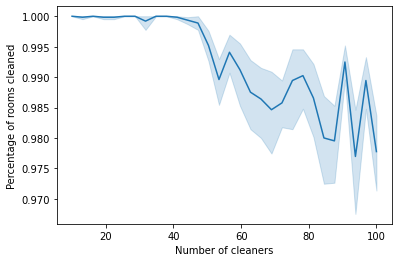

In [23]:
sns.lineplot(
    data=results.arrange_reporters(), 
    x='Number of cleaners', 
    y='Percentage of rooms cleaned'
)

**As demonstrated in the graph located above, the more cleaners that are added to the simulation, the less amount of rooms that get cleaned, however because the movement of the individual cleaners is random, there can be variations where sometimes more rooms are cleaned even though there is a greater amount of cleaners and vice versa.**

<AxesSubplot:xlabel='Number of cleaners', ylabel='Total moves'>

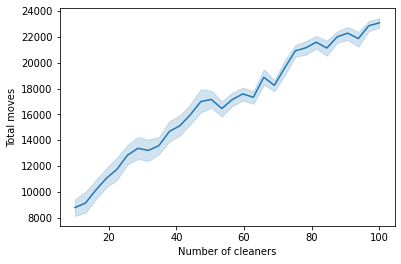

In [24]:
sns.lineplot(
    data=results.arrange_reporters(), 
    x='Number of cleaners', 
    y='Total moves'
)

**As seen in the graph above, adding more cleaners increases the amount of total moves because each cleaner that gets added is adding moves to the total.**

<AxesSubplot:xlabel='Number of cleaners', ylabel='Total time'>

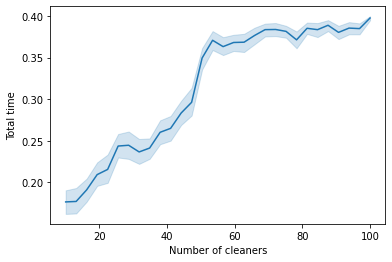

In [25]:
sns.lineplot(
    data=results.arrange_reporters(), 
    x='Number of cleaners', 
    y='Total time' # in seconds
)

**As shown in the graph above, the number of cleaners affects the total amount of time that the simulation will take to run, therefore increasing the amount of cleaners will increase the total time of the program.**